## Project 4 Examples
- Mike Ames 
- amesam@wfu.edu
- 18May2020

### Load Packages
-------



In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.ensemble import ExtraTreesClassifier      #- random trees 
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier 
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier 

# -- we need these to make our pipelines 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

# -- we need these to evaluate our models 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# -- categorical encoders -- 
from category_encoders import *


# -- need this to render charts in notebook -- 
%matplotlib inline


## Tasks 


### Part 1
1. Stage data
2. Clean up column names 
3. Describe data 
4. Explore likely predictors  

### Part 2.
5. Partition into 75/25 split 
6. Train & Evaluate Classifiers
    - ExtraTrees
    - RandomForest 
    - GradientBoosting 
    - Report, accuracy, auc, feature importance, ROC chart and FPR table 
    



# Part 1. 
## 1. Stage 
----- 
import our dataset into a pandas dataframe

In [2]:
df = pd.read_csv("./data/adult.csv",na_values="?")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## 2.  Clean up Column Names

*It's just not fun dealing with ill-formed columns*

- remove leading and trailing characters
- replace spaces with underscores _ 
- change case to lower case
- remove various special characters

In [3]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


# Part 2.
## 5. Partition into 75/25 split 


In [4]:
## Convert income to a 0 / 1 
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

In [5]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))


train pct: 70.00%
test  pct: 30.00%


## 6. Train & Evaluate Classifiers
- ExtraTrees
- RandomForest 
- GradientBoosting 
- Report, accuracy, auc, feature importance, ROC chart and FPR table 

In [6]:
# 1. Split features into categorical and numeric 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        "marital_status",
                        "workclass",
                        "occupation",
                        "education"] 

feature_names = numeric_features + categorical_features

In [17]:
# -- define pipeline --
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('trgenc',  TargetEncoder())  
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

model_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', GradientBoostingClassifier())
])



In [18]:
param_grid = {
            'classifier__learning_rate':[0.001,0.01,0.1],
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [5,10]
    }

In [20]:
# -- setup grid search -- 
gbm_model  = RandomizedSearchCV(model_pipeline, param_grid, n_iter= 3, n_jobs=-1, verbose=3, cv=5, scoring="roc_auc", refit=True)
hpo_search = gbm_model.fit(train[numeric_features + categorical_features], train[target])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


In [19]:
from sklearn.model_selection import ParameterGrid

list(ParameterGrid(param_grid))

[{'classifier__learning_rate': 0.001,
  'classifier__max_depth': 5,
  'classifier__n_estimators': 100},
 {'classifier__learning_rate': 0.001,
  'classifier__max_depth': 5,
  'classifier__n_estimators': 200},
 {'classifier__learning_rate': 0.001,
  'classifier__max_depth': 10,
  'classifier__n_estimators': 100},
 {'classifier__learning_rate': 0.001,
  'classifier__max_depth': 10,
  'classifier__n_estimators': 200},
 {'classifier__learning_rate': 0.01,
  'classifier__max_depth': 5,
  'classifier__n_estimators': 100},
 {'classifier__learning_rate': 0.01,
  'classifier__max_depth': 5,
  'classifier__n_estimators': 200},
 {'classifier__learning_rate': 0.01,
  'classifier__max_depth': 10,
  'classifier__n_estimators': 100},
 {'classifier__learning_rate': 0.01,
  'classifier__max_depth': 10,
  'classifier__n_estimators': 200},
 {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 5,
  'classifier__n_estimators': 100},
 {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 5,


In [9]:
for key in gbm_model.get_params().keys():
    print(key)

cv
error_score
estimator__memory
estimator__steps
estimator__verbose
estimator__preprocess
estimator__classifier
estimator__preprocess__n_jobs
estimator__preprocess__remainder
estimator__preprocess__sparse_threshold
estimator__preprocess__transformer_weights
estimator__preprocess__transformers
estimator__preprocess__verbose
estimator__preprocess__cat
estimator__preprocess__num
estimator__preprocess__cat__memory
estimator__preprocess__cat__steps
estimator__preprocess__cat__verbose
estimator__preprocess__cat__imputer
estimator__preprocess__cat__trgenc
estimator__preprocess__cat__imputer__add_indicator
estimator__preprocess__cat__imputer__copy
estimator__preprocess__cat__imputer__fill_value
estimator__preprocess__cat__imputer__missing_values
estimator__preprocess__cat__imputer__strategy
estimator__preprocess__cat__imputer__verbose
estimator__preprocess__cat__trgenc__cols
estimator__preprocess__cat__trgenc__drop_invariant
estimator__preprocess__cat__trgenc__handle_missing
estimator__prepro

In [21]:
pd.DataFrame(hpo_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,39.943422,19.481528,0.197603,0.109096,200,10,0.1,"{'classifier__n_estimators': 200, 'classifier_...",0.912811,0.924164,0.924819,NaN,0.918917,NaN,NaN,1
1,18.445291,8.744399,0.163145,0.087549,200,5,0.01,"{'classifier__n_estimators': 200, 'classifier_...",0.903465,0.911964,0.919996,NaN,0.911327,NaN,NaN,2
2,19.311858,9.275555,0.101867,0.062453,200,5,0.001,"{'classifier__n_estimators': 200, 'classifier_...",0.889470,0.889984,0.900010,NaN,0.891467,NaN,NaN,3


In [22]:
hpo_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [23]:
gbm_estimator = hpo_search.best_estimator_

gbm_estimator.predict(test[numeric_features + categorical_features])

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
hpo_search.best_params_

{'classifier__n_estimators': 20,
 'classifier__min_samples_leaf': 2,
 'classifier__max_depth': 15,
 'classifier__learning_rate': 0.01}

In [24]:
hpo_search.predict(test[numeric_features + categorical_features])

array([0, 0, 0, ..., 0, 0, 0])

## Create our Pipelines
----
if you are real-slick you can do it all in one pipeline by itteratting over a list of models, but that's "fancy". i'm lazy so i just copy each pipeline. Another thing you can do is try different encoders too. 



Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   13.6s finished


Best parameter (CV auc=nan):
{'classifier__max_depth': 15, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.858
AUC.     0.921
(Test):
Accuracy 0.849
AUC.     0.903


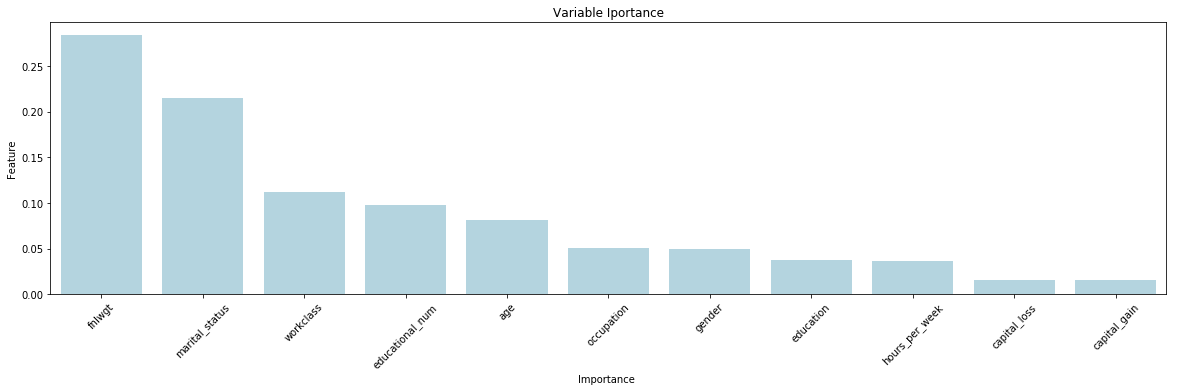

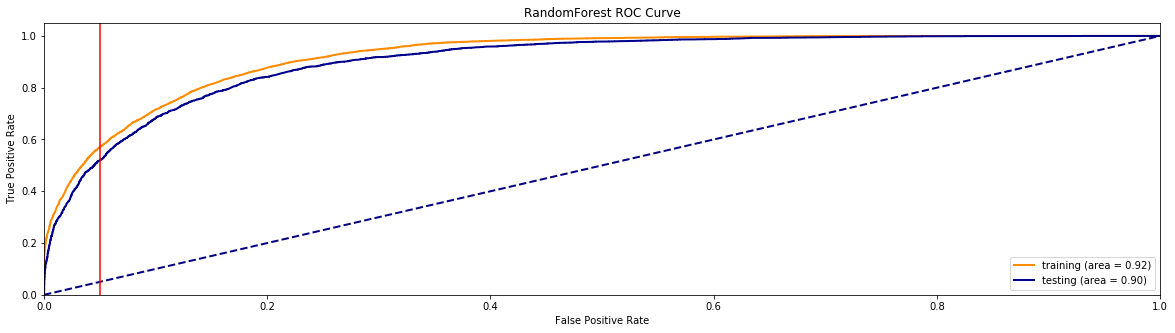

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.20       0.71
1  0.02  0.31       0.64
2  0.03  0.39       0.62
3  0.04  0.46       0.58
4  0.05  0.50       0.53




In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

def model_et_fit(param_grid):
    
    # -- define pipeline --
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('trgenc',  TargetEncoder(smoothing = 2))  
    ])

    numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numeric_features)
        ])

    model_pipeline = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', ExtraTreesClassifier())
    ])
    
    
    # -- setup grid search -- 
    et_model = GridSearchCV(model_pipeline, param_grid, n_jobs=-1, verbose=3, cv=3, scoring="roc_auc", refit=True)
    # -- fit grid search --
    et_model.fit(train[numeric_features + categorical_features], train[target])
    # -- print results -- 
    print("Best parameter (CV auc=%0.3f):" % et_model.best_score_)
    print(et_model.best_params_)
    print("\n")
    
    # -- assess best model, notice refit=True -- 
    train['.pred'] = et_model.predict(train[numeric_features + categorical_features])
    train_probabilites = et_model.predict_proba(train[numeric_features + categorical_features])
    train_fpr, train_tpr, train_thr= roc_curve(train[target], train_probabilites[:,1])
    
    print("--- Training & Test Performance ---")
    print("(Training):")
    print("Accuracy %0.3f" % accuracy_score(train[target], train['.pred']))
    print("AUC.     %0.3f" % auc(train_fpr,train_tpr))
    
    test['.pred'] = et_model.predict(test[numeric_features + categorical_features])
    test_probabilites = et_model.predict_proba(test[numeric_features + categorical_features])
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_probabilites[:,1])
    
    print("(Test):")
    print("Accuracy %0.3f" % accuracy_score(test[target], test['.pred']))
    print("AUC.     %0.3f" % auc(test_fpr,test_tpr))
    
    importance =  et_model.best_estimator_.named_steps["classifier"].feature_importances_
    
    feature_imp ={}
    for i,v in enumerate(importance):
        feature_imp[feature_names[i]] = v
        
     # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(20,5))
    sns.barplot(y="importance", x="feature", data=feature_imp, color="lightblue")
    plt.title( 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()
    
    # -- make ROC charts 
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'RandomForest ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    
    return et_model     

param_grid = {
            # 'classifier__n_estimators': [250, 500, 750],
            'classifier__n_estimators': [10,20],
            'classifier__max_depth': [15,20,25],
            'classifier__min_samples_leaf': [2,4]
    }

et = model_et_fit(param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    9.1s finished


Best parameter (CV auc=nan):
{'classifier__max_depth': 15, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 10}


--- Training & Test Performance ---
(Training):
Accuracy 0.890
AUC.     0.954
(Test):
Accuracy 0.864
AUC.     0.914


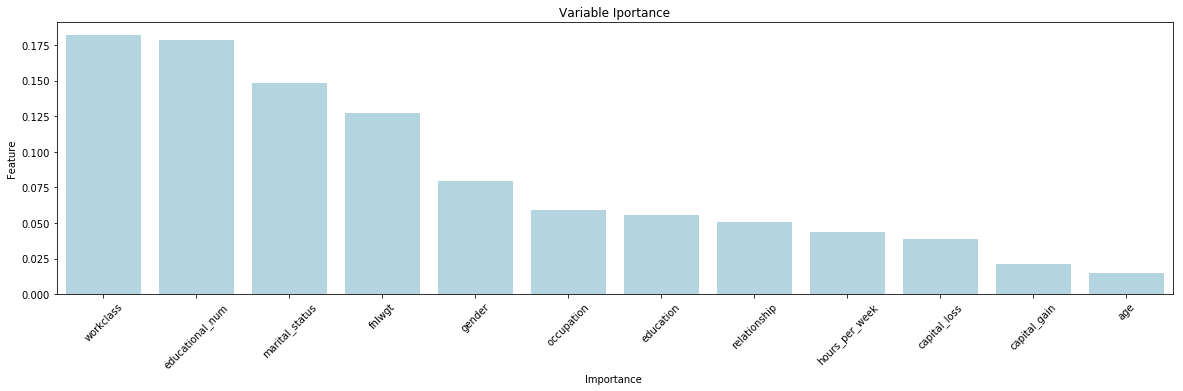

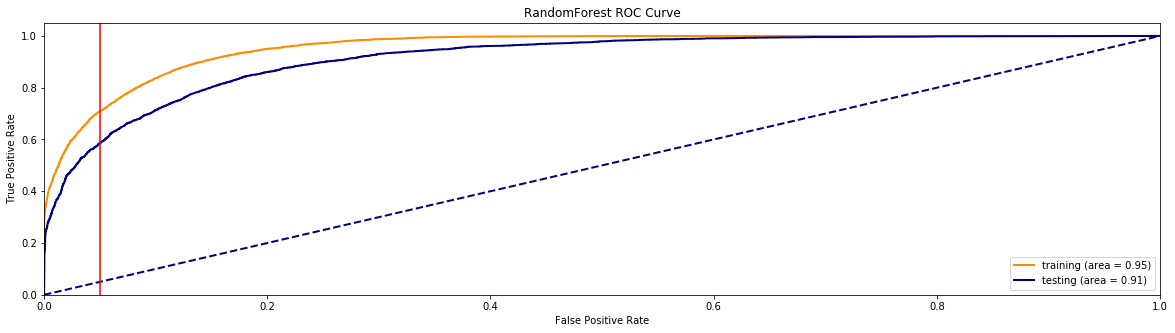

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.29       0.81
1  0.02  0.40       0.73
2  0.03  0.48       0.63
3  0.04  0.53       0.57
4  0.05  0.57       0.53




In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

def model_rf_fit(param_grid):
    
    # -- define pipeline --
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('trgenc',  TargetEncoder(smoothing = 2))  
    ])

    numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numeric_features)
        ])

    model_pipeline = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', RandomForestClassifier())
    ])
    
    
    # -- setup grid search -- 
    rf_model = GridSearchCV(model_pipeline, param_grid, n_jobs=-1, verbose=3, cv=3, scoring="roc_auc", refit=True)
    # -- fit grid search --
    rf_model.fit(train[numeric_features + categorical_features], train[target])
    # -- print results -- 
    print("Best parameter (CV auc=%0.3f):" % rf_model.best_score_)
    print(rf_model.best_params_)
    print("\n")
    
    # -- assess best model, notice refit=True -- 
    train['.pred'] = rf_model.predict(train[numeric_features + categorical_features])
    train_probabilites = rf_model.predict_proba(train[numeric_features + categorical_features])
    train_fpr, train_tpr, train_thr= roc_curve(train[target], train_probabilites[:,1])
    
    print("--- Training & Test Performance ---")
    print("(Training):")
    print("Accuracy %0.3f" % accuracy_score(train[target], train['.pred']))
    print("AUC.     %0.3f" % auc(train_fpr,train_tpr))
    
    test['.pred'] = rf_model.predict(test[numeric_features + categorical_features])
    test_probabilites = rf_model.predict_proba(test[numeric_features + categorical_features])
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_probabilites[:,1])
    
    print("(Test):")
    print("Accuracy %0.3f" % accuracy_score(test[target], test['.pred']))
    print("AUC.     %0.3f" % auc(test_fpr,test_tpr))
    
    importance =  rf_model.best_estimator_.named_steps["classifier"].feature_importances_
    
    feature_imp ={}
    for i,v in enumerate(importance):
        feature_imp[feature_names[i]] = v
        
     # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(20,5))
    sns.barplot(y="importance", x="feature", data=feature_imp, color="lightblue")
    plt.title( 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()
    
    # -- make ROC charts 
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'RandomForest ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    
    return rf_model     

param_grid = {
            'classifier__n_estimators': [10,20],
            'classifier__max_depth': [15,20,25],
            'classifier__min_samples_leaf': [2,4]
    }

rf = model_rf_fit(param_grid)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.9min finished


Best parameter (CV auc=nan):
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 20}


--- Training & Test Performance ---
(Training):
Accuracy 0.759
AUC.     0.900
(Test):
Accuracy 0.765
AUC.     0.895


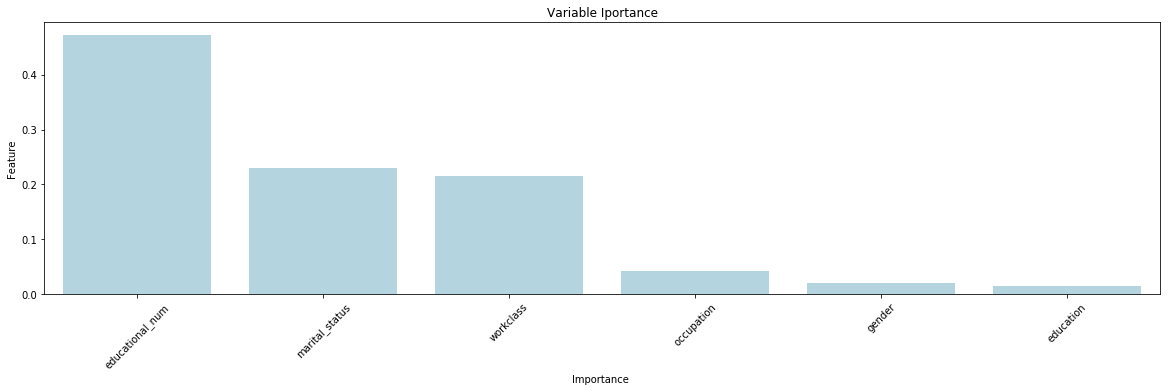

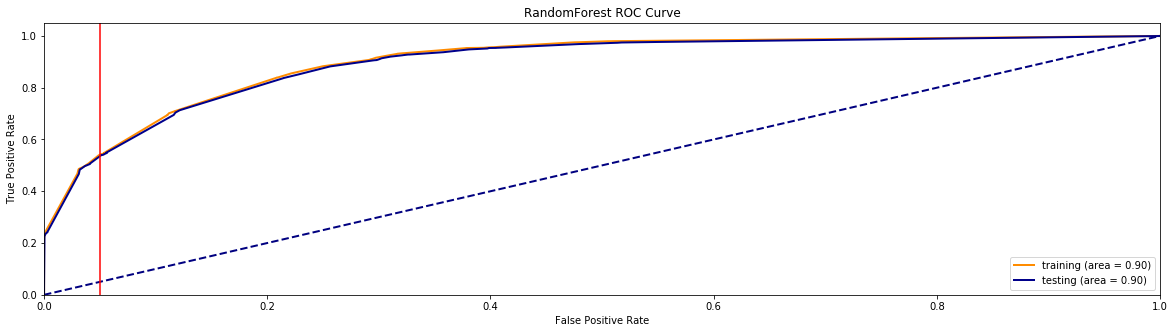

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.03  0.47       0.32
1  0.04  0.50       0.31
2  0.05  0.54       0.30




In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

def model_gbm_fit(param_grid):
    
    # -- define pipeline --
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('trgenc',  TargetEncoder(smoothing = 2))  
    ])

    numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numeric_features)
        ])

    model_pipeline = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', GradientBoostingClassifier())
    ])
    
    
    # -- setup grid search -- 
    gbm_model = GridSearchCV(model_pipeline, param_grid, n_jobs=-1, verbose=3, cv=3, scoring="roc_auc", refit=True)
    # -- fit grid search --
    gbm_model.fit(train[numeric_features + categorical_features], train[target])
    # -- print results -- 
    print("Best parameter (CV auc=%0.3f):" % gbm_model.best_score_)
    print(gbm_model.best_params_)
    print("\n")
    
    # -- assess best model, notice refit=True -- 
    train['.pred'] = gbm_model.predict(train[numeric_features + categorical_features])
    train_probabilites = gbm_model.predict_proba(train[numeric_features + categorical_features])
    train_fpr, train_tpr, train_thr= roc_curve(train[target], train_probabilites[:,1])
    
    print("--- Training & Test Performance ---")
    print("(Training):")
    print("Accuracy %0.3f" % accuracy_score(train[target], train['.pred']))
    print("AUC.     %0.3f" % auc(train_fpr,train_tpr))
    
    test['.pred'] = gbm_model.predict(test[numeric_features + categorical_features])
    test_probabilites = gbm_model.predict_proba(test[numeric_features + categorical_features])
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_probabilites[:,1])
    
    print("(Test):")
    print("Accuracy %0.3f" % accuracy_score(test[target], test['.pred']))
    print("AUC.     %0.3f" % auc(test_fpr,test_tpr))
    
    importance =  gbm_model.best_estimator_.named_steps["classifier"].feature_importances_
    
    feature_imp ={}
    for i,v in enumerate(importance):
        feature_imp[feature_names[i]] = v
        
     # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(20,5))
    sns.barplot(y="importance", x="feature", data=feature_imp, color="lightblue")
    plt.title( 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()
    
    # -- make ROC charts 
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'RandomForest ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    
    return gbm_model     

param_grid = {
            'classifier__learning_rate':[0.01, 0.025, 0.05, 0.1, 0.15, 0.2],
            'classifier__n_estimators': [20,30],
            'classifier__max_depth': [5, 10],
            'classifier__min_samples_leaf': [2,4]
    }

gbm = model_gbm_fit(param_grid)
